In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sqlalchemy import create_engine
from config import load_config

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Loads database config values from database.ini file and validates that user and password are set.
config = load_config()
if (config['user'] == "" or config['password'] == ""):
    print("Please set your user and password in the database.ini file.")
    sys.exit(1)
    
# Creates a connection pool to PostgreSQL database using SQLAlchemy.
engine = create_engine(f"postgresql+psycopg://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}")

In [3]:
df = pd.read_sql("SELECT * FROM tstat_gene_data", engine)
df.head()

,index,Screen,Gene,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,...,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab
0,0,PD_Screen,C29E4.10,-48.494145,-34.970055,-65.781339,94.414318,100.476655,84.836184,-27.128295,...,-0.011484,1.553121,1.470768,-1.869831,1.472592,0.896149,-1.596702,-2.905109,1.625531,0.109856
1,1,PD_Screen,F32D8.13,58.263752,21.351098,65.203746,-25.773717,-0.264180,-33.570599,-1.467973,...,-1.627215,0.132899,0.267636,-1.102273,0.925820,-1.125395,0.070405,-1.441373,1.877379,0.300489
2,2,PD_Screen,F53B2.5,-22.601588,-34.779421,-60.745246,267.864906,260.450831,179.260420,67.135623,...,0.244345,2.022778,1.499078,-0.850941,-1.152332,1.444724,-1.501558,-4.051476,1.517656,0.283562
3,3,PD_Screen,F54B11.5,-62.484385,-82.167243,-113.043862,69.816290,70.269514,61.647391,-45.441001,...,-0.374649,0.102925,-0.109143,-2.990498,-0.774597,-1.738871,-3.106485,-3.490256,0.304232,-0.210618
4,4,PD_Screen,N2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
print(f'Shape:{df.shape}')

Shape:(732, 99)


In [5]:
df.describe()

/Users/gurmehak/miniforge3/envs/rankinlab/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,index,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,Kink,Curve,...,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,...,732.000000,732.000000,732.000000,732.000000,730.000000,732.000000,732.000000,732.000000,720.000000,732.000000
mean,148.633880,-138.145713,-430.207625,-321.061847,-280.878476,-184.281333,-16.902779,114.347164,102.441372,4.993498,...,-1.097551,-0.190087,-0.325159,0.485696,0.740576,0.178890,1.533557,0.754233,0.682783,-0.262224
std,133.081945,183.750843,466.755158,359.921953,316.185826,210.607740,91.621947,138.618392,128.201053,173.821087,...,3.919845,4.873423,3.985663,4.741925,1.943154,5.288512,3.644650,3.848874,2.403269,1.449382
min,0.000000,-1005.656954,-2966.051419,-2721.752386,-1687.407902,-887.941204,-594.722574,-239.220612,-192.585452,-848.570463,...,-25.327189,-22.023897,-20.128498,-15.749503,-5.035088,-21.343535,-12.626542,-14.503847,-8.077057,-6.997452
25%,34.000000,-213.536129,-656.775834,-462.276425,-469.052210,-319.541240,-68.267143,4.289668,0.000000,-93.010048,...,-2.775545,-2.572067,-2.153658,-2.109216,-0.615782,-2.583129,-0.695733,-1.659828,-0.545546,-1.136892
50%,95.000000,-85.575027,-293.953046,-222.893239,-222.304864,-168.938512,-11.524490,103.415831,95.384297,-1.219962,...,-0.546423,0.031654,-0.019831,0.795068,0.790290,0.441415,1.230987,0.717607,0.765332,-0.231514
75%,256.250000,-16.058306,-101.486759,-74.037370,-36.843403,-18.157627,40.200335,197.924950,184.169284,104.711075,...,0.993022,2.634686,1.965196,3.308364,1.708762,3.234019,3.443810,3.043947,1.817898,0.658783
max,439.000000,247.116934,259.321845,236.012683,385.971427,371.001420,247.627798,787.782873,655.452185,608.510077,...,13.148285,33.674442,16.702961,21.112297,18.237958,18.895693,21.586750,15.611046,21.327711,4.305627


In [6]:
# Accessing missingness 
df.groupby("Screen").apply(lambda x: x.isna().sum())

/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_96775/779939292.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("Screen").apply(lambda x: x.isna().sum())


,index,Screen,Gene,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,...,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab
Screen,,,,,,,,,,,,,,,,,,,,,
ASD_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
ASD_WGS_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
Glia_Genes_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Neuron_Genes_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PD_GWAS_Locus71_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PD_Screen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,6,0


In [7]:
df

,index,Screen,Gene,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,...,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab
0,0,PD_Screen,C29E4.10,-48.494145,-34.970055,-65.781339,94.414318,100.476655,84.836184,-27.128295,...,-0.011484,1.553121,1.470768,-1.869831,1.472592,0.896149,-1.596702,-2.905109,1.625531,0.109856
1,1,PD_Screen,F32D8.13,58.263752,21.351098,65.203746,-25.773717,-0.264180,-33.570599,-1.467973,...,-1.627215,0.132899,0.267636,-1.102273,0.925820,-1.125395,0.070405,-1.441373,1.877379,0.300489
2,2,PD_Screen,F53B2.5,-22.601588,-34.779421,-60.745246,267.864906,260.450831,179.260420,67.135623,...,0.244345,2.022778,1.499078,-0.850941,-1.152332,1.444724,-1.501558,-4.051476,1.517656,0.283562
3,3,PD_Screen,F54B11.5,-62.484385,-82.167243,-113.043862,69.816290,70.269514,61.647391,-45.441001,...,-0.374649,0.102925,-0.109143,-2.990498,-0.774597,-1.738871,-3.106485,-3.490256,0.304232,-0.210618
4,4,PD_Screen,N2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,3,PD_GWAS_Locus71_Screen,clec-52,-23.488354,-90.997012,-75.944231,-217.061236,-151.211361,-51.348749,-121.950271,...,-1.449581,-1.236164,-5.110772,-2.899321,1.613221,-6.070975,-2.552811,-3.134880,-1.730266,-1.919299
728,4,PD_GWAS_Locus71_Screen,dog-1,-53.288002,-201.744282,-238.224215,-112.308852,-76.398087,11.977647,107.753998,...,-3.581153,-0.491266,-1.203408,-1.932733,-0.934653,-0.355651,-0.905917,-2.354599,0.080724,-1.314617
729,5,PD_GWAS_Locus71_Screen,let-19,151.162335,-703.193124,-269.549110,-352.056416,-50.558732,62.327347,507.538979,...,-6.374322,-9.595027,-5.980291,-11.444356,6.070362,-12.126958,-7.524877,-8.237045,2.104314,-0.053593
730,6,PD_GWAS_Locus71_Screen,tbx-2,-79.686664,-107.447994,-145.017842,13.646374,54.578569,13.223478,-56.982193,...,-2.958309,-4.202564,-1.518877,-6.441494,0.219382,-4.939754,-3.422904,-4.946408,0.915475,1.212796


In [8]:
# Assessing uniqueness of categorical column

df[['Screen', 'Gene']].nunique()

Screen      6
Gene      680
dtype: int64

In [9]:
# Drop 'infs' to make sure code doesnt break 

df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

## Preprocessing 

- Imputation: choose a dummy value like -10 (for now picking -9999) - numeric only
- Scaling - numeric only
- Encoding: One Hot Encoding - categorical column only

In [10]:
df.columns

Index(['index', 'Screen', 'Gene', 'Morphwidth', 'Midline', 'Area', 'Speed',
       'Bias', 'Angular Speed', 'Aspect Ratio', 'Kink', 'Curve', 'Crab',
       'Pathlength', 'Initial Response Duration',
       'Initial Response Probability', 'Initial Response Speed',
       'Final Response Duration', 'Final Response Probability',
       'Final Response Speed', 'Habituation of Response Duration',
       'Habituation of Response Probability', 'Habituation of Response Speed',
       'Spontaneous Recovery of Response Duration',
       'Spontaneous Recovery of Response Probability',
       'Spontaneous Recovery of Response Speed',
       'Memory Retention of Response Duration',
       'Memory Retention of Response Probability',
       'Memory Retention of Response Speed', 'Initial PSA Speed',
       'Final PSA Speed', 'Recovery PSA Speed', 'Peak PSA Speed',
       'Peak Tap Number of PSA Speed', 'Average PSA Speed',
       'Sensitization of PSA Speed', 'Habituation of PSA Speed',
       'Sponta

In [11]:
df.dtypes

index                                 int64
Screen                               object
Gene                                 object
Morphwidth                          float64
Midline                             float64
                                     ...   
Average PSA Crab                    float64
Sensitization of PSA Crab           float64
Habituation of PSA Crab             float64
Spontaneous Recovery of PSA Crab    float64
Memory Retention of PSA Crab        float64
Length: 99, dtype: object

In [12]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [13]:
df.dtypes.value_counts()

float64    96
object      2
int64       1
Name: count, dtype: int64

In [14]:
# numeric_cols.value_counts().sum()

In [15]:
# Numerical columns: Impute missing values then scale
numeric_cols = df.select_dtypes(include='number').columns
si = SimpleImputer(strategy="constant", fill_value=-9999)
scaler = StandardScaler()
numerical_transformer = make_pipeline(si, scaler)

# Categorical Columns
categorical_cols = ['Screen', 'Gene']
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype = int)
categorical_transformer = make_pipeline(ohe)

# Apply transformations
preprocessor = make_column_transformer(
    (numerical_transformer, numeric_cols),
    (categorical_transformer, categorical_cols),
    remainder="passthrough" 
)

X = preprocessor.fit_transform(df)

In [16]:
# Number of new columns added

X.shape[1] - df.shape[1]

683

Clustering 

In [17]:
kmeans = KMeans(n_clusters=6, n_init='auto', random_state=100)
labels = kmeans.fit_predict(X)
df['Cluster'] = labels
labels

/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_96775/1809139114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = labels


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 3, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4,
       1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 3, 1, 3,
       3, 1, 3, 1, 1, 1, 1, 4, 3, 4, 1, 4, 1, 2, 3, 1, 1, 1, 3, 4, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 4, 3, 1, 3, 4, 1, 1, 1, 3, 1, 1, 1,
       1, 4, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1,

# Elbow method to determine suitable k value

In [18]:
def plot_elbow(w, h, inertia_values, x):
    plt.figure(figsize=(w, h))
    plt.axvline(x=3, linestyle="-.", c="black")
    plt.plot(range(1, x), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h))
    ax.set_xlabel("K", fontsize=w+h)
    ax.set_ylabel("Inertia", fontsize=w+h)

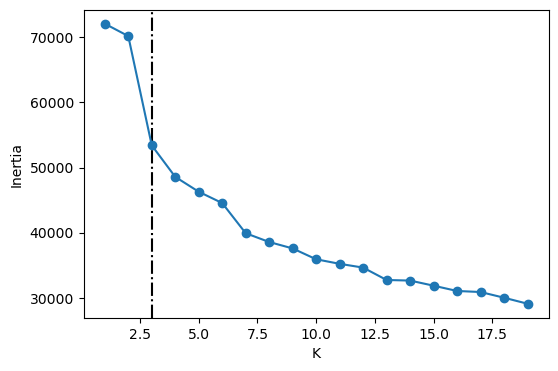

In [19]:
inertia_values = list()
x = 20
for k in range(1, x):
    inertia_values.append(KMeans(n_clusters=k, n_init='auto').fit(X).inertia_)
plot_elbow(6, 4, inertia_values, x)

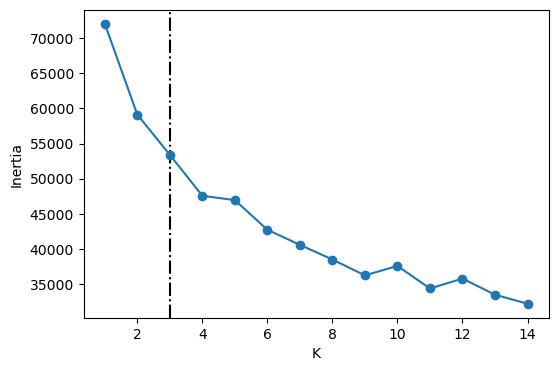

In [20]:
inertia_values = list()
x = 15
for k in range(1, x):
    inertia_values.append(KMeans(n_clusters=k, n_init='auto').fit(X).inertia_)
plot_elbow(6, 4, inertia_values, x)

Picking k = [2,6]

## Dimensionality reduction

In [21]:
print("initial shape:")
X.shape

initial shape:


(731, 782)

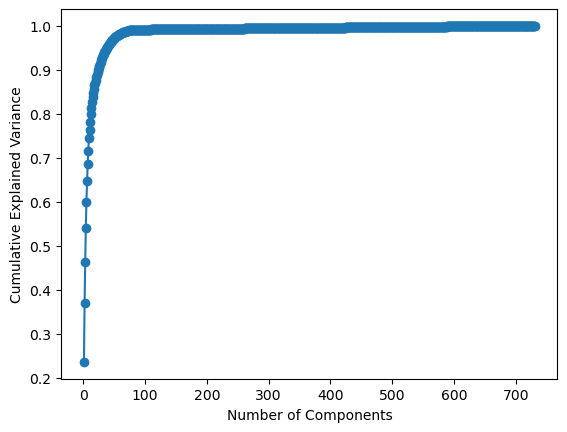

In [22]:
pca = PCA()
pca.fit(X)

import matplotlib.pyplot as plt
plt.plot(range(1, 732),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [23]:
len(pca.explained_variance_ratio_)

731

Picking 100 as the reduced dimesnion

In [46]:
pca = PCA(n_components=100)
pca_df = pca.fit_transform(X)

In [47]:
pca.explained_variance_ratio_.sum()

np.float64(0.9915870959581076)

In [48]:
pca_df.shape

(731, 100)

In [29]:
kmeans = KMeans(n_clusters=100, n_init='auto', random_state=100)
labels = kmeans.fit_predict(pca_df)
df['Cluster'] = labels
df

/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_96775/880095796.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = labels


,index,Screen,Gene,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,...,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab,Cluster
0,0,PD_Screen,C29E4.10,-48.494145,-34.970055,-65.781339,94.414318,100.476655,84.836184,-27.128295,...,1.553121,1.470768,-1.869831,1.472592,0.896149,-1.596702,-2.905109,1.625531,0.109856,2
1,1,PD_Screen,F32D8.13,58.263752,21.351098,65.203746,-25.773717,-0.264180,-33.570599,-1.467973,...,0.132899,0.267636,-1.102273,0.925820,-1.125395,0.070405,-1.441373,1.877379,0.300489,45
2,2,PD_Screen,F53B2.5,-22.601588,-34.779421,-60.745246,267.864906,260.450831,179.260420,67.135623,...,2.022778,1.499078,-0.850941,-1.152332,1.444724,-1.501558,-4.051476,1.517656,0.283562,60
3,3,PD_Screen,F54B11.5,-62.484385,-82.167243,-113.043862,69.816290,70.269514,61.647391,-45.441001,...,0.102925,-0.109143,-2.990498,-0.774597,-1.738871,-3.106485,-3.490256,0.304232,-0.210618,2
4,4,PD_Screen,N2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,3,PD_GWAS_Locus71_Screen,clec-52,-23.488354,-90.997012,-75.944231,-217.061236,-151.211361,-51.348749,-121.950271,...,-1.236164,-5.110772,-2.899321,1.613221,-6.070975,-2.552811,-3.134880,-1.730266,-1.919299,14
728,4,PD_GWAS_Locus71_Screen,dog-1,-53.288002,-201.744282,-238.224215,-112.308852,-76.398087,11.977647,107.753998,...,-0.491266,-1.203408,-1.932733,-0.934653,-0.355651,-0.905917,-2.354599,0.080724,-1.314617,18
729,5,PD_GWAS_Locus71_Screen,let-19,151.162335,-703.193124,-269.549110,-352.056416,-50.558732,62.327347,507.538979,...,-9.595027,-5.980291,-11.444356,6.070362,-12.126958,-7.524877,-8.237045,2.104314,-0.053593,75
730,6,PD_GWAS_Locus71_Screen,tbx-2,-79.686664,-107.447994,-145.017842,13.646374,54.578569,13.223478,-56.982193,...,-4.202564,-1.518877,-6.441494,0.219382,-4.939754,-3.422904,-4.946408,0.915475,1.212796,37


In [194]:
# kmeans_df = pca_df.copy()
# kemans_df['Cluster'] = labels

Top features contributing to the clusters

In [30]:
pc1_df = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'weight': pca.components_[0]
})

pc1_df.sort_values(ascending=False, by='weight')

,feature,weight
25,pipeline-1__Memory Retention of Response Proba...,0.169451
24,pipeline-1__Memory Retention of Response Duration,0.169450
26,pipeline-1__Memory Retention of Response Speed,0.169448
22,pipeline-1__Spontaneous Recovery of Response P...,0.169446
21,pipeline-1__Spontaneous Recovery of Response D...,0.169446
...,...,...
72,pipeline-1__Average PSA Kink,-0.153861
7,pipeline-1__Aspect Ratio,-0.154016
62,pipeline-1__Average PSA Aspect Ratio,-0.158110
60,pipeline-1__Peak PSA Aspect Ratio,-0.159193


In [31]:
pca_df

array([[ 6.82860787e+00,  4.38188378e-01, -4.54790948e-01, ...,
         1.76174498e-02,  7.06272839e-03, -8.54509047e-03],
       [ 4.99382565e+00,  2.00659052e-01,  2.10607036e-01, ...,
         4.73446008e-03, -1.69523215e-02, -2.47415170e-03],
       [ 5.97739066e+00,  2.04095151e+00, -4.55395996e-01, ...,
         1.02943787e-02,  3.03182118e-03,  1.90511412e-02],
       ...,
       [-5.47036659e-02, -7.12606420e+00,  1.77587917e+00, ...,
        -8.38172471e-03,  1.46474141e-02, -1.67127227e-03],
       [ 7.57502842e+00, -2.99115511e+00,  1.39760432e+00, ...,
         2.10004355e-03,  8.83046769e-03,  2.90536517e-02],
       [ 7.85849850e+00, -4.19427385e+00,  1.37956789e+00, ...,
        -1.60627918e-02, -2.11172991e-02, -1.41023093e-02]],
      shape=(731, 100))

In [34]:
# plt.figure(figsize=(10, 7))
# plt.scatter(pca_df[:, 0], pca_df[:, 1], c=labels, cmap='viridis', alpha=0.5)
# plt.title('K-Means Clusters on First 2 PCA Components')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.colorbar(label='Cluster')
# plt.show()

/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_96775/65507582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = labels


ValueError: Unrecognized marker style 'O'

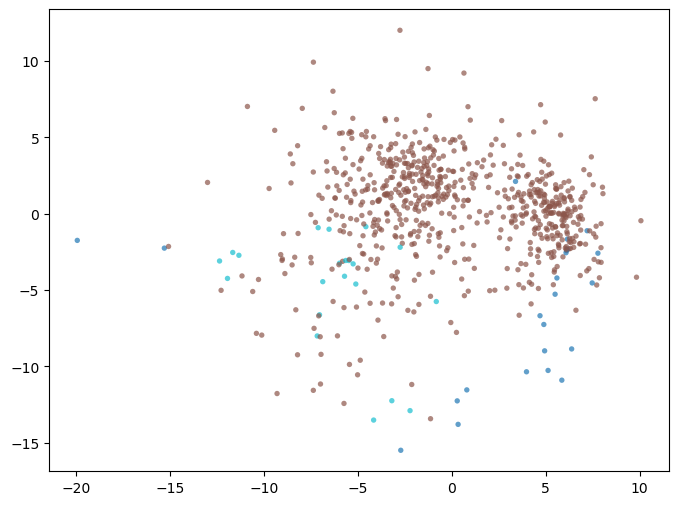

In [45]:
df["cluster"] = labels


pca_df_vis = PCA(n_components=2, random_state=100)
labels_vis = pca_df_vis.fit_transform(pca_df)                     
centers_vis = pca_df_vis.transform(kmeans.cluster_centers_)
method = "PCA(2)"

plt.figure(figsize=(8,6))
plt.scatter(labels_vis[:, 0], labels_vis[:, 1], c=labels, cmap="tab10", alpha=0.7, s=15, linewidths=0)
plt.scatter(centers_vis[:, 0], centers_vis[:, 1], marker="O", s=10, c="black", label="Centroid")
plt.title(f"Clusters (assigned in 100D)")
# plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, metric="euclidean")
labels = clusterer.fit_predict(pca_df)  

/Users/gurmehak/miniforge3/envs/rankinlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gurmehak/miniforge3/envs/rankinlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [43]:
df["cluster2"] = labels

/var/folders/mp/57zdplyn4kl5d5l8mxcwwknr0000gn/T/ipykernel_96775/2082770077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster2"] = labels


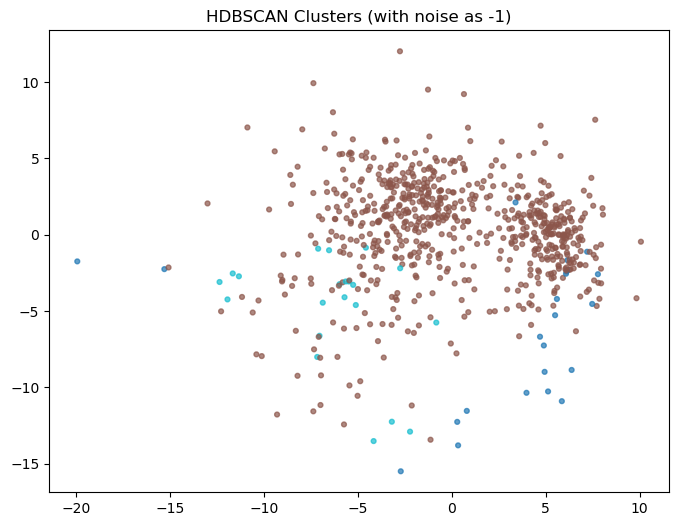

In [44]:
pca_vis = PCA(n_components=2, random_state=100)
Z = pca_vis.fit_transform(pca_df)

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=labels, cmap="tab10", s=12, alpha=0.7)
plt.title("HDBSCAN Clusters (with noise as -1)")
plt.show()

In [189]:
# import plotly.express as px

# coords = PCA(n_components=2).fit_transform(X)

# pca_df = pd.DataFrame(coords, columns=["PC1","PC2"])
# pca_df["Cluster"] = labels
# pca_df["Gene"] = df["Gene"].values
# pca_df["Screen"] = df["Screen"].values

# fig = px.scatter(
#     pca_df, x="PC1", y="PC2", color="Cluster",
#     hover_data=["Gene","Screen"], opacity=0.9
# )
# fig.show()

In [ ]:
# def discrete_scatter(x1, x2, y=None, markers=None, s=8, ax=None,
#                      labels=None, padding=.2, alpha=1, c=None, markeredgewidth=0.6, 
#                      label_points=False, x1_annot=-0.1, x2_annot=0.2):
#     """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
#     Parameters
#     ----------
#     x1 : nd-array
#         input data, first axis
#     x2 : nd-array
#         input data, second axis
#     y : nd-array
#         input data, discrete labels
#     cmap : colormap
#         Colormap to use.
#     markers : list of string
#         List of markers to use, or None (which defaults to 'o').
#     s : int or float
#         Size of the marker
#     padding : float
#         Fraction of the dataset range to use for padding the axes.
#     alpha : float
#         Alpha value for all points.
#     """
#     if ax is None:
#         ax = plt.gca()

#     if y is None:
#         y = np.zeros(len(x1))        

#     # unique_y = np.unique(y)
#     unique_y, inds = np.unique(y, return_index=True)    

#     if markers is None:
#         markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

#     if len(markers) == 1:
#         markers = markers * len(unique_y)

#     if labels is None:
#         labels = unique_y

#     # lines in the matplotlib sense, not actual lines
#     lines = []


#     if len(unique_y) == 1: 
#         cr = [-1]
#     else: 
#         cr = sorted([y[index] for index in sorted(inds)])

#     if c is not None and len(c) == 1: 
#         cr = c
    
#     for (i, (yy, color_ind)) in enumerate(zip(unique_y, cr)):
#         mask = y == yy
#         # print(f'color_ind= {color_ind} and i = {i}')
#         # if c is none, use color cycle
#         color = colors[color_ind]
#         # print('color: ', color)
#         # use light edge for dark markers
#         if np.mean(colorConverter.to_rgb(color)) < .2:
#             markeredgecolor = "grey"
#         else:
#             markeredgecolor = "black"

#         lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
#                              label=labels[i], alpha=alpha, c=color,                             
#                              markeredgewidth=markeredgewidth,
#                              markeredgecolor=markeredgecolor)[0])
#     if label_points: 
#         labs = [str(label) for label in list(range(0,len(x1)))]
#         for i, txt in enumerate(labs):
#             font_size=9
#             ax.annotate(txt, (x1[i]+0.2, x2[i]+0.2), xytext= (x1[i]+x1_annot, x2[i]+x2_annot), c='k', size = font_size)

#     return lines    

# def plot_kmeans_circles(kmeans, X, n_clusters=3, ax=None):
#     km_labels = kmeans.fit_predict(X)
#     centers = kmeans.cluster_centers_
#     # plot the input data
#     ax = ax or plt.gca()
#     ax.axis('equal')
#     discrete_scatter(X[:,0], X[:,1], km_labels, c=km_labels, markers='o', markeredgewidth=0.2, ax=ax);
#     discrete_scatter(
#         centers[:, 0], centers[:, 1], y=[0,1,2], markers="*", s=18
#     );
#     radii = [cdist(X[km_labels == i], [center]).max()
#              for i, center in enumerate(centers)]
#     for center, radius in zip(centers, radii):
#         ax.add_patch(plt.Circle(center, radius, fc='gray', alpha=0.4))

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [193]:
# import seaborn as sns

# # Create DataFrame with clusters
# df = pd.DataFrame(X, columns=['Feature1', 'Feature2'])
# df['Cluster'] = labels

# # Scatter plot with seaborn
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x='Feature1', y='Feature2', hue='Cluster', palette='viridis')
# plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red')
# plt.title('K-Means Clustering with Seaborn')
# plt.show()

In [ ]:
d = pd.read_sql("SELECT * FROM tap_response_data", engine)

In [55]:
d.head()

,Screen,dataset,Gene,Allele,Plate_id,Date,taps,plate,time,Duration,dist,Probability,Speed,PSA Speed,PSA Bias,PSA Aspect Ratio,PSA Kink,PSA Curve,PSA Crab
0,PD_Screen,C29E4.10_ok2752,C29E4.10,ok2752,20230710_104441_B0706ea,20230710,1.0,1.0,599.983,3.49,0.579,0.645833,0.165903,0.064750,0.157500,0.435900,68.320000,38.920000,0.010860
1,PD_Screen,C29E4.10_ok2752,C29E4.10,ok2752,20230710_104441_B0706ea,20230710,2.0,1.0,609.886,3.08,0.632,0.519231,0.205195,0.155022,0.441944,0.424056,68.833333,38.350000,0.022233
2,PD_Screen,C29E4.10_ok2752,C29E4.10,ok2752,20230710_104441_B0706ea,20230710,3.0,1.0,619.955,1.96,0.441,0.622642,0.225000,0.196569,0.761885,0.347308,56.380769,35.723077,0.023438
3,PD_Screen,C29E4.10_ok2752,C29E4.10,ok2752,20230710_104441_B0706ea,20230710,4.0,1.0,629.982,1.82,0.433,0.569444,0.237912,0.173472,0.796500,0.332111,53.738889,34.622222,0.019378
4,PD_Screen,C29E4.10_ok2752,C29E4.10,ok2752,20230710_104441_B0706ea,20230710,5.0,1.0,639.913,1.88,0.455,0.558824,0.242021,0.181033,0.818444,0.314889,51.277778,34.488889,0.019711


In [56]:
d[d['taps']=='inf']

,Screen,dataset,Gene,Allele,Plate_id,Date,taps,plate,time,Duration,dist,Probability,Speed,PSA Speed,PSA Bias,PSA Aspect Ratio,PSA Kink,PSA Curve,PSA Crab


In [58]:
d[d['Screen']=='ASD_Screen']['taps'].unique()

array([ 5., 15.,  6., 16.,  1.,  2.,  3.,  4.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31.])

In [75]:
d[d['Screen']=='ASD_Screen']

,Screen,dataset,Gene,Allele,Plate_id,Date,taps,plate,time,Duration,dist,Probability,Speed,PSA Speed,PSA Bias,PSA Aspect Ratio,PSA Kink,PSA Curve,PSA Crab
41075,ASD_Screen,pax-2_ok3078,pax-2,ok3078,20190626_161516_C0626mc,20190626,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.205877,0.915825,0.280421,41.207018,32.101754,0.028354
42226,ASD_Screen,N2,N2,N2,20150516_111130_C0516ac,20150516,15.0,2.0,739.982,0.89,0.200,0.764706,0.224719,0.209274,0.868098,0.275967,46.537705,28.739344,0.016470
42467,ASD_Screen,pax-2_ok3078,pax-2,ok3078,20190626_161516_C0626mc,20190626,6.0,NaN,NaN,NaN,NaN,NaN,NaN,0.215569,0.906276,0.303103,45.151724,33.386207,0.026966
43031,ASD_Screen,N2,N2,N2,20150516_111130_C0516ac,20150516,16.0,2.0,749.984,0.39,0.099,0.478261,0.253846,0.180963,0.896952,0.295065,47.566129,31.946774,0.017098
43497,ASD_Screen,C25H3.11_gk425293,C25H3.11,gk425293,20151117_092907_B1117ba,20151117,1.0,1.0,599.931,2.98,0.558,0.941176,0.187248,0.088615,0.142758,0.424273,72.345455,37.306061,0.013364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68939,ASD_Screen,ztf-6_tm1803,ztf-6,tm1803,20160526_161911_C0526ed,20160526,27.0,5.0,859.994,1.56,0.228,0.600000,0.146154,0.059477,0.476129,0.264113,38.230645,28.759677,0.008105
68940,ASD_Screen,ztf-6_tm1803,ztf-6,tm1803,20160526_161911_C0526ed,20160526,28.0,5.0,869.960,1.45,0.237,0.250000,0.163448,0.059987,0.287565,0.236790,42.790323,27.633871,0.008202
68941,ASD_Screen,ztf-6_tm1803,ztf-6,tm1803,20160526_161911_C0526ed,20160526,29.0,5.0,879.999,1.63,0.224,0.333333,0.137423,0.055465,0.367177,0.279661,41.704839,28.587097,0.009513
68942,ASD_Screen,ztf-6_tm1803,ztf-6,tm1803,20160526_161911_C0526ed,20160526,30.0,5.0,889.958,3.43,0.656,0.333333,0.191254,0.059658,0.500258,0.315242,50.106452,29.301613,0.009466


In [60]:
psa = pd.read_sql("SELECT * FROM psa_summarised_data", engine)
psa.head()

,Screen,dataset,Gene,Allele,Plate_id,Date,Experiment,Initial PSA Speed,Final PSA Speed,Recovery PSA Speed,Peak PSA Speed,Peak Tap Number of PSA Speed,Average PSA Speed,Sensitization of PSA Speed,Habituation of PSA Speed,Spontaneous Recovery of PSA Speed,Memory Retention of PSA Speed,Initial PSA Bias,Final PSA Bias,Recovery PSA Bias,Peak PSA Bias,Peak Tap Number of PSA Bias,Average PSA Bias,Sensitization of PSA Bias,Habituation of PSA Bias,Spontaneous Recovery of PSA Bias,Memory Retention of PSA Bias,Initial PSA Angular Speed,Final PSA Angular Speed,Recovery PSA Angular Speed,Peak PSA Angular Speed,Peak Tap Number of PSA Angular Speed,Average PSA Angular Speed,Sensitization of PSA Angular Speed,Habituation of PSA Angular Speed,Spontaneous Recovery of PSA Angular Speed,Memory Retention of PSA Angular Speed,Initial PSA Aspect Ratio,Final PSA Aspect Ratio,Recovery PSA Aspect Ratio,Peak PSA Aspect Ratio,Peak Tap Number of PSA Aspect Ratio,Average PSA Aspect Ratio,Sensitization of PSA Aspect Ratio,Habituation of PSA Aspect Ratio,Spontaneous Recovery of PSA Aspect Ratio,Memory Retention of PSA Aspect Ratio,Initial PSA Kink,Final PSA Kink,Recovery PSA Kink,Peak PSA Kink,Peak Tap Number of PSA Kink,Average PSA Kink,Sensitization of PSA Kink,Habituation of PSA Kink,Spontaneous Recovery of PSA Kink,Memory Retention of PSA Kink,Initial PSA Curve,Final PSA Curve,Recovery PSA Curve,Peak PSA Curve,Peak Tap Number of PSA Curve,Average PSA Curve,Sensitization of PSA Curve,Habituation of PSA Curve,Spontaneous Recovery of PSA Curve,Memory Retention of PSA Curve,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab
0,PD_Screen,N2,N2,N2,20221102_154144_C1029bc,20221102,1,0.100768,0.143539,0.076825,0.182390,7.0,0.150949,0.081622,0.038851,23.760411,0.066714,0.400857,0.879188,0.376650,0.934414,13.0,0.832455,0.533557,0.055226,6.038845,0.502538,8.557143,4.666698,5.190000,8.557143,1.0,5.353648,0.000000,3.890445,39.348915,-0.523302,0.343250,0.229964,0.333300,0.343250,1.0,0.244158,0.000000,0.113286,-2.898762,0.103336,59.571429,39.094665,57.695000,59.571429,1.0,42.133431,0.000000,20.476763,-3.149880,18.600335,34.821429,27.699148,35.005000,35.005000,31.0,29.271319,0.183571,7.305852,0.527179,7.305852,0.012729,0.010293,0.010635,0.015019,4.0,0.011424,0.002291,0.004727,-16.447811,0.000342
1,PD_Screen,N2,N2,N2,20220510_183526_C0506ab,20220510,2,0.083806,0.183861,0.115679,0.280798,15.0,0.115189,0.196992,0.096938,-38.031077,0.068182,0.250000,0.906246,0.712053,1.000000,14.0,0.453452,0.750000,0.093754,-184.821053,0.194194,2.816129,5.172308,10.471053,31.786885,21.0,6.544742,28.970756,26.614577,-271.824320,-5.298744,0.357919,0.216816,0.409211,0.903689,21.0,0.193006,0.545769,0.686873,14.330371,0.192395,53.835484,37.543145,56.710526,142.208197,21.0,32.845122,88.372713,104.665052,5.340423,19.167382,41.816129,26.551881,33.268421,44.757895,2.0,19.514867,2.941766,18.206014,-20.441175,6.716540,0.009874,0.011680,0.016489,0.048561,2.0,0.012998,0.038687,0.036882,66.995650,0.004810
2,PD_Screen,N2,N2,N2,20220510_185420_A0506aa,20220510,3,0.100892,0.168071,0.119136,0.212098,5.0,0.173856,0.111207,0.044027,-18.083368,0.048935,0.404254,0.813858,0.544806,0.937525,24.0,0.809715,0.533271,0.123667,-34.768051,0.269053,6.103390,5.249657,5.672222,11.350000,3.0,6.583778,5.246610,6.100343,7.064396,-0.422565,0.370017,0.239109,0.358583,0.370017,1.0,0.263908,0.000000,0.130908,-3.090025,0.119475,59.535593,42.792646,59.200000,59.535593,1.0,44.945305,0.000000,16.742947,-0.563685,16.407354,36.410169,29.602911,37.530556,37.530556,31.0,30.671814,1.120386,7.927644,3.077124,7.927644,0.013081,0.012847,0.015069,0.021390,3.0,0.014382,0.008308,0.008543,15.197878,0.002223
3,PD_Screen,N2,N2,N2,20220510_192657_B0506ac,20220510,4,0.138958,0.145975,0.074537,0.193593,6.0,0.159845,0.054635,0.047618,46.360046,0.071439,0.603115,0.792625,0.480632,0.9404

In [ ]:
psa[psa['Peak Tap Number of PSA Angular Speed']=='inf']

,Screen,dataset,Gene,Allele,Plate_id,Date,Experiment,Initial PSA Speed,Final PSA Speed,Recovery PSA Speed,Peak PSA Speed,Peak Tap Number of PSA Speed,Average PSA Speed,Sensitization of PSA Speed,Habituation of PSA Speed,Spontaneous Recovery of PSA Speed,Memory Retention of PSA Speed,Initial PSA Bias,Final PSA Bias,Recovery PSA Bias,Peak PSA Bias,Peak Tap Number of PSA Bias,Average PSA Bias,Sensitization of PSA Bias,Habituation of PSA Bias,Spontaneous Recovery of PSA Bias,Memory Retention of PSA Bias,Initial PSA Angular Speed,Final PSA Angular Speed,Recovery PSA Angular Speed,Peak PSA Angular Speed,Peak Tap Number of PSA Angular Speed,Average PSA Angular Speed,Sensitization of PSA Angular Speed,Habituation of PSA Angular Speed,Spontaneous Recovery of PSA Angular Speed,Memory Retention of PSA Angular Speed,Initial PSA Aspect Ratio,Final PSA Aspect Ratio,Recovery PSA Aspect Ratio,Peak PSA Aspect Ratio,Peak Tap Number of PSA Aspect Ratio,Average PSA Aspect Ratio,Sensitization of PSA Aspect Ratio,Habituation of PSA Aspect Ratio,Spontaneous Recovery of PSA Aspect Ratio,Memory Retention of PSA Aspect Ratio,Initial PSA Kink,Final PSA Kink,Recovery PSA Kink,Peak PSA Kink,Peak Tap Number of PSA Kink,Average PSA Kink,Sensitization of PSA Kink,Habituation of PSA Kink,Spontaneous Recovery of PSA Kink,Memory Retention of PSA Kink,Initial PSA Curve,Final PSA Curve,Recovery PSA Curve,Peak PSA Curve,Peak Tap Number of PSA Curve,Average PSA Curve,Sensitization of PSA Curve,Habituation of PSA Curve,Spontaneous Recovery of PSA Curve,Memory Retention of PSA Curve,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab


In [70]:
df[df['Peak Tap Number of PSA Angular Speed']=='inf']

,index,Screen,Gene,Morphwidth,Midline,Area,Speed,Bias,Angular Speed,Aspect Ratio,Kink,Curve,Crab,Pathlength,Initial Response Duration,Initial Response Probability,Initial Response Speed,Final Response Duration,Final Response Probability,Final Response Speed,Habituation of Response Duration,Habituation of Response Probability,Habituation of Response Speed,Spontaneous Recovery of Response Duration,Spontaneous Recovery of Response Probability,Spontaneous Recovery of Response Speed,Memory Retention of Response Duration,Memory Retention of Response Probability,Memory Retention of Response Speed,Initial PSA Speed,Final PSA Speed,Recovery PSA Speed,Peak PSA Speed,Peak Tap Number of PSA Speed,Average PSA Speed,Sensitization of PSA Speed,Habituation of PSA Speed,Spontaneous Recovery of PSA Speed,Memory Retention of PSA Speed,Initial PSA Bias,Final PSA Bias,Recovery PSA Bias,Peak PSA Bias,Peak Tap Number of PSA Bias,Average PSA Bias,Sensitization of PSA Bias,Habituation of PSA Bias,Spontaneous Recovery of PSA Bias,Memory Retention of PSA Bias,Initial PSA Angular Speed,Final PSA Angular Speed,Recovery PSA Angular Speed,Peak PSA Angular Speed,Peak Tap Number of PSA Angular Speed,Average PSA Angular Speed,Sensitization of PSA Angular Speed,Habituation of PSA Angular Speed,Spontaneous Recovery of PSA Angular Speed,Memory Retention of PSA Angular Speed,Initial PSA Aspect Ratio,Final PSA Aspect Ratio,Recovery PSA Aspect Ratio,Peak PSA Aspect Ratio,Peak Tap Number of PSA Aspect Ratio,Average PSA Aspect Ratio,Sensitization of PSA Aspect Ratio,Habituation of PSA Aspect Ratio,Spontaneous Recovery of PSA Aspect Ratio,Memory Retention of PSA Aspect Ratio,Initial PSA Kink,Final PSA Kink,Recovery PSA Kink,Peak PSA Kink,Peak Tap Number of PSA Kink,Average PSA Kink,Sensitization of PSA Kink,Habituation of PSA Kink,Spontaneous Recovery of PSA Kink,Memory Retention of PSA Kink,Initial PSA Curve,Final PSA Curve,Recovery PSA Curve,Peak PSA Curve,Peak Tap Number of PSA Curve,Average PSA Curve,Sensitization of PSA Curve,Habituation of PSA Curve,Spontaneous Recovery of PSA Curve,Memory Retention of PSA Curve,Initial PSA Crab,Final PSA Crab,Recovery PSA Crab,Peak PSA Crab,Peak Tap Number of PSA Crab,Average PSA Crab,Sensitization of PSA Crab,Habituation of PSA Crab,Spontaneous Recovery of PSA Crab,Memory Retention of PSA Crab


In [71]:
df['Peak Tap Number of PSA Angular Speed'].sort_values(ascending=False)

117          inf
443    12.302763
380    10.762241
729    10.471754
306    10.167823
         ...    
393    -3.415650
274    -3.900067
248    -3.900067
88           NaN
97           NaN
Name: Peak Tap Number of PSA Angular Speed, Length: 732, dtype: float64